# Importing the Dataset

In [10]:
IMAGE_DIR = "/kaggle/input/brain-tumor-mri-dataset/brain_tumor_dataset/brain_tumor_segmentation/train/images"
LABEL_DIR = "/kaggle/input/brain-tumor-mri-dataset/brain_tumor_dataset/brain_tumor_segmentation/train/labels"

# Libraries imported

In [11]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, threshold_sauvola

# Dice and jaccard score was defined by the given formulas in class

i just played with the constant value in the denominator from the range 1e-4 to 1e-8 i get decent result with one of the thresholding method at 1e-5 so i kept it like that. as mentioned in the class we use this constant to the denominator for not getting it to 0.

In [12]:
def dice_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2 * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-5)

def jaccard_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / (union + 1e-5)

> here i'm converting the labels to mast by using yolo_seg_to_mask so i can use that mask for evaluation

In [13]:
def yolo_seg_to_mask(label_path, img_shape):
    h, w = img_shape
    mask = np.zeros((h, w), dtype=np.uint8)

    with open(label_path, "r") as f:
        for line in f:
            values = list(map(float, line.split()))
            coords = values[1:]

            points = []
            for i in range(0, len(coords), 2):
                x = int(coords[i] * w)
                y = int(coords[i+1] * h)
                points.append([x, y])

            points = np.array(points, dtype=np.int32)
            cv2.fillPoly(mask, [points], 1)

    return mask

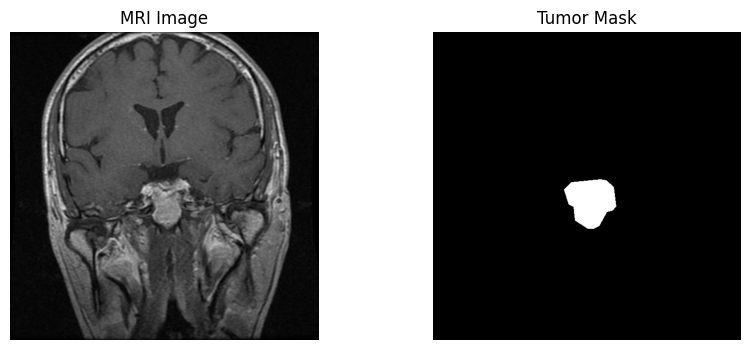

In [14]:
img_name = sorted(os.listdir(IMAGE_DIR))[15]

image = cv2.imread(os.path.join(IMAGE_DIR, img_name), cv2.IMREAD_GRAYSCALE)
label_name = os.path.splitext(img_name)[0] + ".txt"
mask = yolo_seg_to_mask(os.path.join(LABEL_DIR, label_name), image.shape)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title("MRI Image")
plt.imshow(image, cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Tumor Mask")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.show()


In [15]:
dice_otsu, jaccard_otsu = [], []

for img_name in sorted(os.listdir(IMAGE_DIR)):
    image = cv2.imread(os.path.join(IMAGE_DIR, img_name), cv2.IMREAD_GRAYSCALE)
    label_name = os.path.splitext(img_name)[0] + ".txt"
    mask = yolo_seg_to_mask(os.path.join(LABEL_DIR, label_name), image.shape)

    image = cv2.resize(image, (256,256))
    mask = cv2.resize(mask, (256,256))
    mask = (mask > 0).astype(np.uint8)


    otsu_seg = (image > threshold_otsu(image)).astype(np.uint8)

    dice_otsu.append(dice_score(mask, otsu_seg))
    jaccard_otsu.append(jaccard_score(mask, otsu_seg))

print("OTSU RESULTS")
print("Dice:", np.mean(dice_otsu))
print("Jaccard:", np.mean(jaccard_otsu))


OTSU RESULTS
Dice: 0.10161079299828796
Jaccard: 0.05791598791923496


> defined the sauvola function as we discussed in class and later on played with the tunebale parameters , choosen the values which usually fits best.

In [16]:
def sauvola_manual(image, window_size=25, k=0.3, R=128):

    image = image.astype(np.float32)

    # Local mean
    mean = cv2.boxFilter(image, ddepth=-1, ksize=(window_size, window_size))

    # Local squared mean
    sq_mean = cv2.boxFilter(image**2, ddepth=-1, ksize=(window_size, window_size))

    # Variance
    variance = sq_mean - mean**2

    # Standard deviation
    std = np.sqrt(np.maximum(variance, 0))

    # Sauvola formula
    threshold = mean * (1 + k * ((std / R) - 1))

    # Binary segmentation
    segmentation = (image > threshold).astype(np.uint8)

    return segmentation


In [19]:
window_sizes = [15, 25, 35, 51]
k_values = [0.1, 0.2, 0.3, 0.4, 0.5]

best_dice = 0
best_jaccard = 0
best_params = None

for w in window_sizes:
    for k in k_values:

        dice_sauvola = []
        jaccard_sauvola = []

        for img_name in sorted(os.listdir(IMAGE_DIR)):
            image = cv2.imread(os.path.join(IMAGE_DIR, img_name), cv2.IMREAD_GRAYSCALE)
            label_name = os.path.splitext(img_name)[0] + ".txt"
            mask = yolo_seg_to_mask(os.path.join(LABEL_DIR, label_name), image.shape)

            image = cv2.resize(image, (256,256))
            mask = cv2.resize(mask, (256,256))
            mask = (mask > 0).astype(np.uint8)

            sauvola_seg = sauvola_manual(image, window_size=w, k=k, R=128)

            dice_sauvola.append(dice_score(mask, sauvola_seg))
            jaccard_sauvola.append(jaccard_score(mask, sauvola_seg))

        avg_dice = np.mean(dice_sauvola)
        avg_jaccard = np.mean(jaccard_sauvola)

        print(f"Window={w}, k={k}")
        print(f"Dice={avg_dice:.4f}, Jaccard={avg_jaccard:.4f}")
        print("-----------------------------")

        if avg_dice > best_dice:
            best_dice = avg_dice
            best_jaccard = avg_jaccard
            best_params = (w, k)

print("Best Parameters:", best_params)
print("Best Dice:", best_dice)
print("Best Jaccard:", best_jaccard)


Window=15, k=0.1
Dice=0.0632, Jaccard=0.0336
-----------------------------
Window=15, k=0.2
Dice=0.0618, Jaccard=0.0328
-----------------------------
Window=15, k=0.3
Dice=0.0606, Jaccard=0.0321
-----------------------------
Window=15, k=0.4
Dice=0.0596, Jaccard=0.0315
-----------------------------
Window=15, k=0.5
Dice=0.0588, Jaccard=0.0310
-----------------------------
Window=25, k=0.1
Dice=0.0672, Jaccard=0.0359
-----------------------------
Window=25, k=0.2
Dice=0.0650, Jaccard=0.0346
-----------------------------
Window=25, k=0.3
Dice=0.0634, Jaccard=0.0337
-----------------------------
Window=25, k=0.4
Dice=0.0622, Jaccard=0.0330
-----------------------------
Window=25, k=0.5
Dice=0.0614, Jaccard=0.0325
-----------------------------
Window=35, k=0.1
Dice=0.0709, Jaccard=0.0379
-----------------------------
Window=35, k=0.2
Dice=0.0680, Jaccard=0.0363
-----------------------------
Window=35, k=0.3
Dice=0.0659, Jaccard=0.0351
-----------------------------
Window=35, k=0.4
Dice=0.0

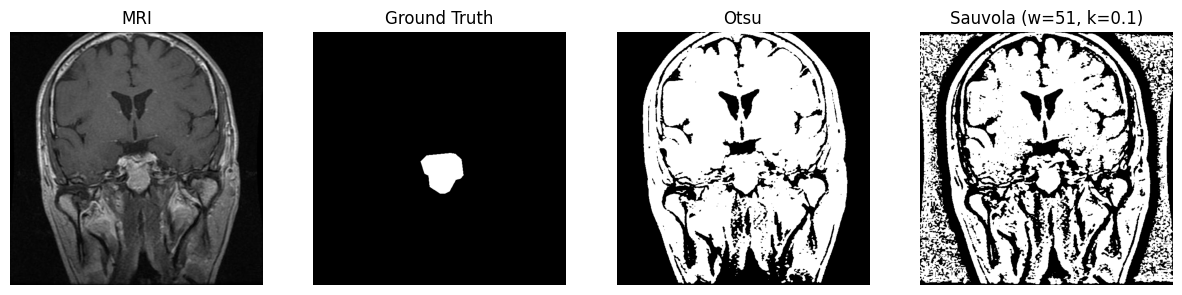

In [20]:
img_name = sorted(os.listdir(IMAGE_DIR))[15]

image = cv2.imread(os.path.join(IMAGE_DIR, img_name), cv2.IMREAD_GRAYSCALE)
label_name = os.path.splitext(img_name)[0] + ".txt"
mask = yolo_seg_to_mask(os.path.join(LABEL_DIR, label_name), image.shape)

best_w, best_k = best_params

otsu_seg = (image > threshold_otsu(image)).astype(np.uint8)
sauvola_seg = sauvola_manual(image, window_size=best_w, k=best_k, R=128)

plt.figure(figsize=(15,4))

plt.subplot(1,4,1)
plt.title("MRI")
plt.imshow(image, cmap="gray")
plt.axis("off")

plt.subplot(1,4,2)
plt.title("Ground Truth")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.subplot(1,4,3)
plt.title("Otsu")
plt.imshow(otsu_seg, cmap="gray")
plt.axis("off")

plt.subplot(1,4,4)
plt.title(f"Sauvola (w={best_w}, k={best_k})")
plt.imshow(sauvola_seg, cmap="gray")
plt.axis("off")

plt.show()
